# AnnoMI Synergistic Analysis - Cognitive Actions × Rich Annotations

This notebook **combines** cognitive action predictions with detailed annotation data to unlock new research avenues.

**Data Integration:**
- ✅ Cognitive actions from `all_predictions.json` (filtered, high-confidence)
- ✅ Rich annotations from `AnnoMI-full.csv` (first annotation per utterance)
- ✅ Unified dataset enabling cross-modal analysis

**New Experimental Avenues:**
1. 🎯 **Cognitive Signatures of MI Techniques** - Which cognitive patterns emerge during open questions vs complex reflections?
2. 🔄 **Annotation-Cognitive Co-occurrence** - How do therapist behaviors and cognitive actions co-occur?
3. 📈 **Predictive Modeling** - Can we predict MI quality from combined features?
4. 🌊 **Multi-modal Flow Analysis** - How do annotation subtypes and cognitive actions flow together?
5. 🎭 **Client Response Patterns** - What cognitive patterns follow specific therapist techniques?
6. 🔍 **Change Talk Cognitive-Behavioral Profiling** - Dual-lens view of change mechanisms
7. 🧠 **Breakthrough Moment Annotation Context** - What therapist behaviors precede breakthroughs?

## 1️⃣ Setup and Data Integration

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from itertools import combinations
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

print("✅ Libraries loaded")

✅ Libraries loaded


In [2]:
# Load AnnoMI-full.csv (with rich annotations)
print("📥 Loading AnnoMI-full.csv...")
df_full = pd.read_csv('third_party/AnnoMI/AnnoMI-full.csv')

# Take first annotation per utterance
df_annotations = df_full.groupby(['transcript_id', 'utterance_id']).first().reset_index()
print(f"✅ Loaded {len(df_annotations)} annotated utterances")

# Load cognitive action predictions
print("\n📥 Loading cognitive action predictions...")
with open('output/analysis_AnnoMI/all_predictions.json', 'r') as f:
    all_predictions = json.load(f)

df_predictions = pd.DataFrame(all_predictions)
print(f"✅ Loaded {len(df_predictions)} cognitive predictions")

# Merge datasets
print("\n🔗 Merging annotations with cognitive predictions...")
df = df_annotations.merge(
    df_predictions[['transcript_id', 'utterance_id', 'predictions', 'action_layer_details']],
    on=['transcript_id', 'utterance_id'],
    how='inner'
)

print(f"✅ Merged dataset: {len(df)} utterances")
print(f"\n📊 Dataset Overview:")
print(f"   Transcripts: {df['transcript_id'].nunique()}")
print(f"   Topics: {df['topic'].nunique()}")
print(f"   Therapist: {len(df[df['interlocutor'] == 'therapist'])}")
print(f"   Client: {len(df[df['interlocutor'] == 'client'])}")

📥 Loading AnnoMI-full.csv...
✅ Loaded 9699 annotated utterances

📥 Loading cognitive action predictions...
✅ Loaded 9699 cognitive predictions

🔗 Merging annotations with cognitive predictions...
✅ Merged dataset: 9699 utterances

📊 Dataset Overview:
   Transcripts: 133
   Topics: 44
   Therapist: 4882
   Client: 4817


## 2️⃣ Data Preparation

In [3]:
# Filter short utterances
MIN_LENGTH = 10
df['utterance_length'] = df['utterance_text'].str.len()
df = df[df['utterance_length'] >= MIN_LENGTH].copy()

print(f"🔄 Filtered to {len(df)} utterances (>= {MIN_LENGTH} chars)")

# Extract high-confidence cognitive actions
def extract_high_confidence_actions(row):
    """Extract cognitive actions with >2 layers OR 100% confidence"""
    if pd.isna(row['predictions']):
        return []
    
    predictions = row['predictions']
    action_layer_details = row.get('action_layer_details', {})
    
    active = []
    for action, data in predictions.items():
        if not data.get('is_active', False):
            continue
        
        num_layers = len(action_layer_details.get(action, []))
        max_confidence = max(
            [layer['confidence'] for layer in action_layer_details.get(action, [])],
            default=0
        )
        
        if num_layers > 3 or max_confidence >= 1.0:
            active.append({
                'action': action,
                'confidence': data['aggregate'],
                'num_layers': num_layers
            })
    return active

df['active_actions'] = df.apply(extract_high_confidence_actions, axis=1)
df['num_active_actions'] = df['active_actions'].apply(len)
df['action_names'] = df['active_actions'].apply(lambda x: [a['action'] for a in x])

# Get all unique actions
all_actions = sorted(set(
    action for actions in df['action_names'] for action in actions
))

print(f"\n🧠 Cognitive Actions:")
print(f"   Unique actions: {len(all_actions)}")
print(f"   Mean per utterance: {df['num_active_actions'].mean():.2f}")
print(f"   Utterances with actions: {(df['num_active_actions'] > 0).sum()} ({(df['num_active_actions'] > 0).sum()/len(df)*100:.1f}%)")

🔄 Filtered to 7372 utterances (>= 10 chars)

🧠 Cognitive Actions:
   Unique actions: 45
   Mean per utterance: 3.99
   Utterances with actions: 7287 (98.8%)


## 3️⃣ Experiment 1: Cognitive Signatures of MI Techniques

**Question:** What cognitive patterns distinguish different MI techniques?

In [4]:
print("="*80)
print("COGNITIVE SIGNATURES OF MI TECHNIQUES")
print("="*80)

therapist_df = df[df['interlocutor'] == 'therapist'].copy()

# Define MI technique categories with annotation details
techniques = {
    'open_question': (therapist_df['question_subtype'] == 'open'),
    'closed_question': (therapist_df['question_subtype'] == 'closed'),
    'simple_reflection': (therapist_df['reflection_subtype'] == 'simple'),
    'complex_reflection': (therapist_df['reflection_subtype'] == 'complex'),
    'giving_information': (therapist_df['therapist_input_subtype'] == 'giving information'),
    'affirm': (therapist_df['therapist_input_subtype'] == 'affirm'),
}

# Extract cognitive signatures for each technique
technique_signatures = {}

for technique_name, mask in techniques.items():
    subset = therapist_df[mask]
    if len(subset) < 10:
        continue
    
    # Aggregate cognitive actions
    actions = Counter()
    for _, row in subset.iterrows():
        for action_data in row['active_actions']:
            actions[action_data['action']] += action_data['confidence']
    
    # Normalize by count
    total = sum(actions.values())
    signature = {action: score/total for action, score in actions.most_common(10)}
    
    technique_signatures[technique_name] = {
        'count': len(subset),
        'signature': signature,
        'top_actions': actions.most_common(10)
    }

# Display signatures
for technique, data in technique_signatures.items():
    print(f"\n{'='*80}")
    print(f"{technique.upper().replace('_', ' ')} (n={data['count']})")
    print(f"{'='*80}")
    for action, score in data['top_actions']:
        print(f"   {action:35s} {score:7.2f} ({data['signature'][action]*100:5.1f}%)")

COGNITIVE SIGNATURES OF MI TECHNIQUES

OPEN QUESTION (n=949)
   noticing                             402.00 ( 10.6%)
   questioning                          351.02 (  9.2%)
   response_modulation                  292.76 (  7.7%)
   divergent_thinking                   269.19 (  7.1%)
   self_questioning                     259.63 (  6.8%)
   convergent_thinking                  174.97 (  4.6%)
   emotion_understanding                172.00 (  4.5%)
   abstracting                          152.05 (  4.0%)
   perspective_taking                   138.00 (  3.6%)
   reframing                            125.03 (  3.3%)

CLOSED QUESTION (n=676)
   noticing                             279.00 ( 10.2%)
   questioning                          251.53 (  9.2%)
   response_modulation                  232.74 (  8.5%)
   self_questioning                     224.97 (  8.2%)
   divergent_thinking                   133.00 (  4.9%)
   reframing                            129.62 (  4.7%)
   evaluating     

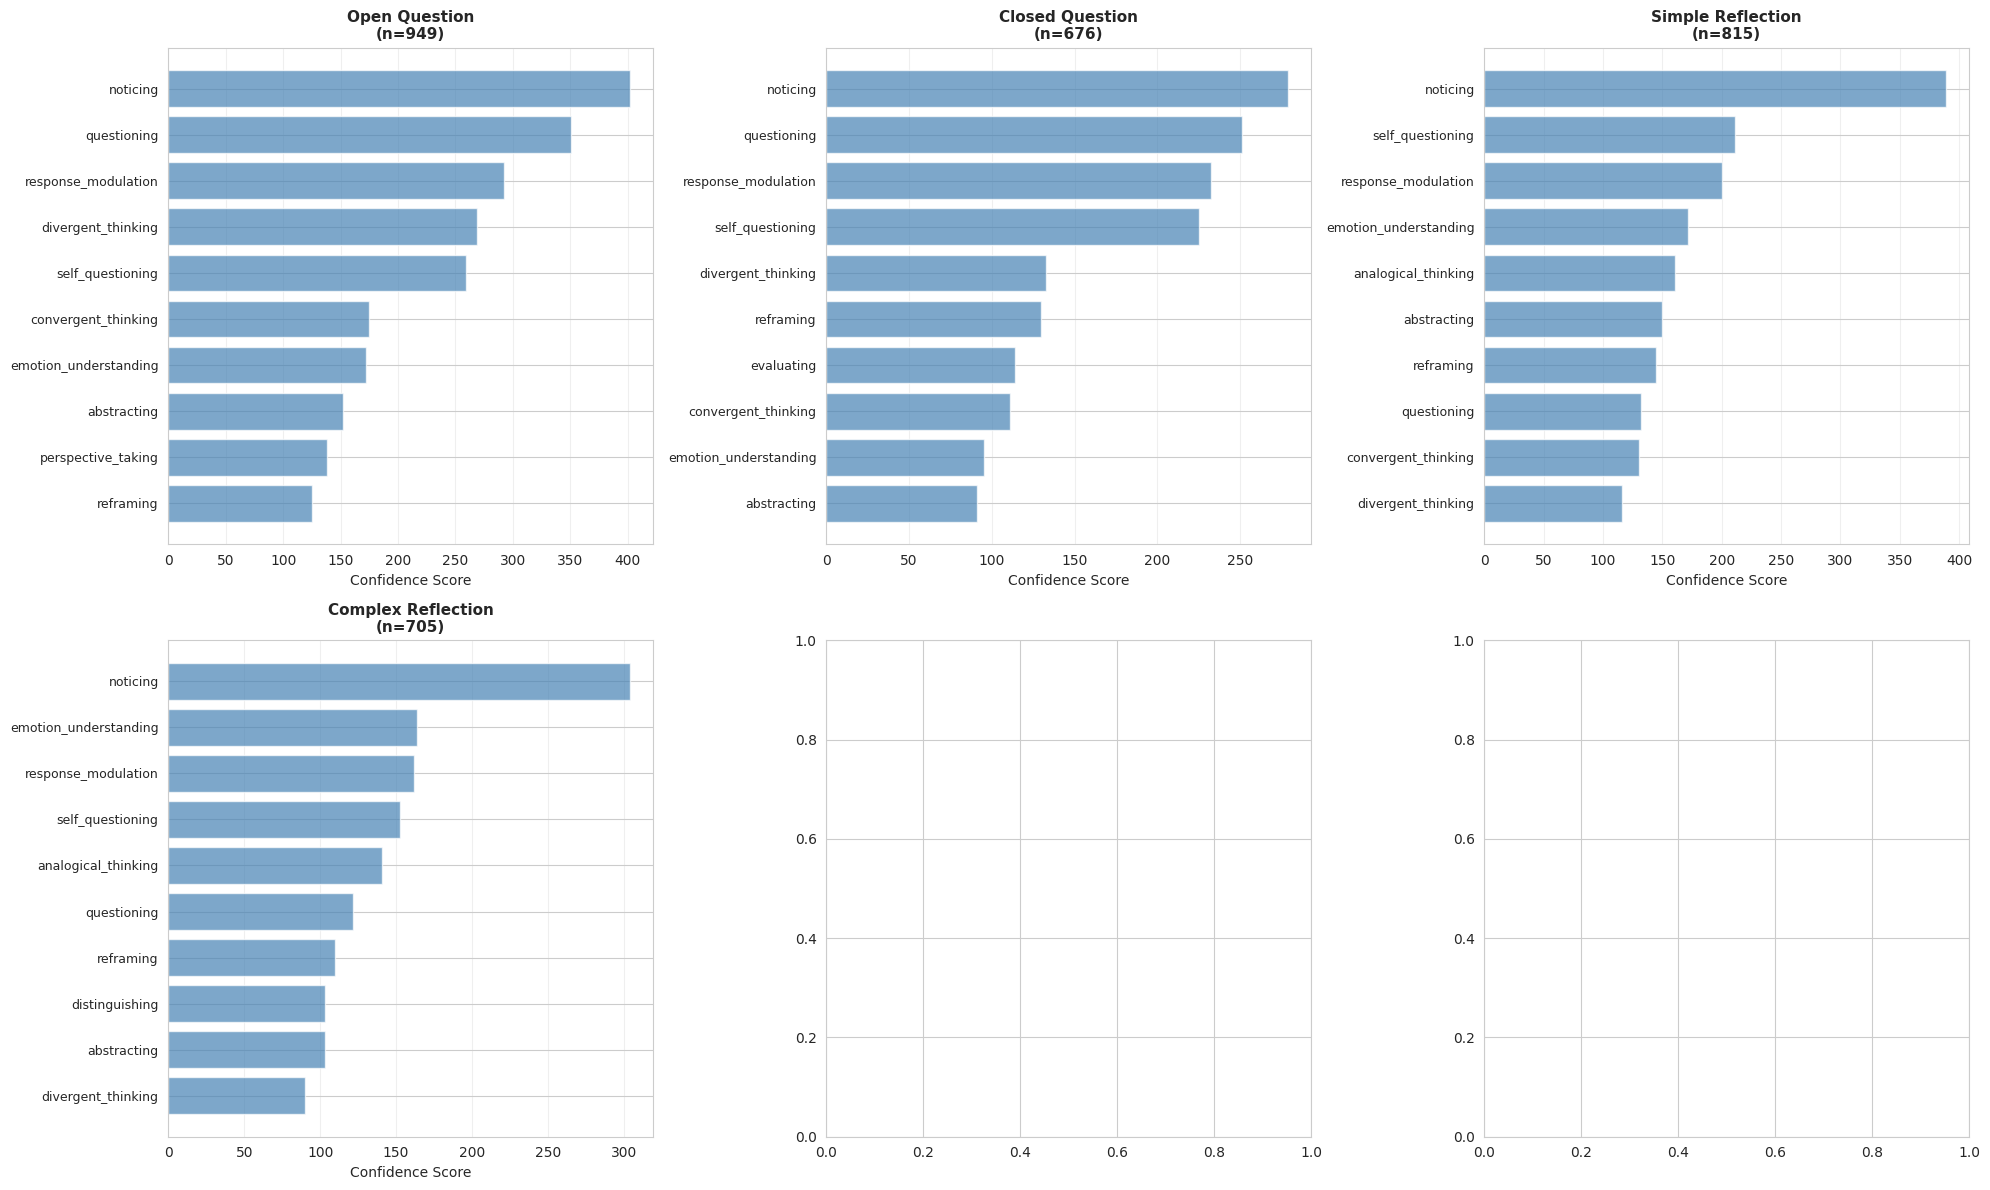

✅ Visualization saved: output/analysis_AnnoMI/synergy_1_technique_signatures.png


In [5]:
# Visualize cognitive signature comparison
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for idx, (technique, data) in enumerate(technique_signatures.items()):
    if idx >= 6:
        break
    
    actions = [a for a, _ in data['top_actions']]
    scores = [s for _, s in data['top_actions']]
    
    axes[idx].barh(range(len(actions)), scores, color='steelblue', alpha=0.7)
    axes[idx].set_yticks(range(len(actions)))
    axes[idx].set_yticklabels(actions, fontsize=9)
    axes[idx].set_xlabel('Confidence Score', fontsize=10)
    axes[idx].set_title(f"{technique.replace('_', ' ').title()}\n(n={data['count']})",
                       fontsize=11, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='x')
    axes[idx].invert_yaxis()

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/synergy_1_technique_signatures.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/synergy_1_technique_signatures.png")

## 4️⃣ Experiment 2: Annotation-Cognitive Co-occurrence Patterns

**Question:** Which annotation subtypes co-occur with which cognitive actions?

In [6]:
print("="*80)
print("ANNOTATION-COGNITIVE CO-OCCURRENCE ANALYSIS")
print("="*80)

# Create annotation-cognitive co-occurrence matrix
# For each utterance, record what annotation subtype and cognitive actions co-occur

cooccurrence_patterns = []

for _, row in therapist_df.iterrows():
    # Get annotation type
    ann_type = None
    if row['reflection_exists'] == True:
        ann_type = f"reflect_{row['reflection_subtype']}"
    elif row['question_exists'] == True:
        ann_type = f"question_{row['question_subtype']}"
    elif row['therapist_input_exists'] == True:
        ann_type = f"input_{row['therapist_input_subtype']}"
    
    if ann_type and pd.notna(ann_type):
        for action_data in row['active_actions']:
            cooccurrence_patterns.append({
                'annotation': ann_type,
                'cognitive_action': action_data['action'],
                'confidence': action_data['confidence']
            })

cooccur_df = pd.DataFrame(cooccurrence_patterns)

# Create pivot table
cooccur_pivot = cooccur_df.pivot_table(
    index='annotation',
    columns='cognitive_action',
    values='confidence',
    aggfunc='sum',
    fill_value=0
)

# Normalize by row
cooccur_normalized = cooccur_pivot.div(cooccur_pivot.sum(axis=1), axis=0)

print(f"\n✅ Created co-occurrence matrix: {cooccur_pivot.shape}")
print(f"   Annotation types: {len(cooccur_pivot)}")
print(f"   Cognitive actions: {len(cooccur_pivot.columns)}")

# Find strongest associations
print("\n" + "="*80)
print("STRONGEST ANNOTATION-COGNITIVE ASSOCIATIONS")
print("="*80)

associations = []
for ann in cooccur_normalized.index:
    for action in cooccur_normalized.columns:
        score = cooccur_normalized.loc[ann, action]
        if score > 0:
            associations.append((ann, action, score))

associations.sort(key=lambda x: x[2], reverse=True)

print("\nTop 20 strongest associations:")
for i, (ann, action, score) in enumerate(associations[:20], 1):
    print(f"{i:2d}. {ann:30s} <-> {action:30s} ({score*100:5.1f}%)")

ANNOTATION-COGNITIVE CO-OCCURRENCE ANALYSIS

✅ Created co-occurrence matrix: (8, 45)
   Annotation types: 8
   Cognitive actions: 45

STRONGEST ANNOTATION-COGNITIVE ASSOCIATIONS

Top 20 strongest associations:
 1. input_information              <-> noticing                       ( 14.3%)
 2. input_options                  <-> response_modulation            ( 12.7%)
 3. reflect_simple                 <-> noticing                       ( 12.6%)
 4. input_negotiation              <-> response_modulation            ( 11.7%)
 5. reflect_complex                <-> noticing                       ( 11.5%)
 6. input_advice                   <-> noticing                       ( 11.4%)
 7. input_negotiation              <-> noticing                       ( 11.1%)
 8. input_options                  <-> noticing                       ( 11.1%)
 9. question_open                  <-> noticing                       ( 10.8%)
10. question_closed                <-> noticing                       ( 10.4%)


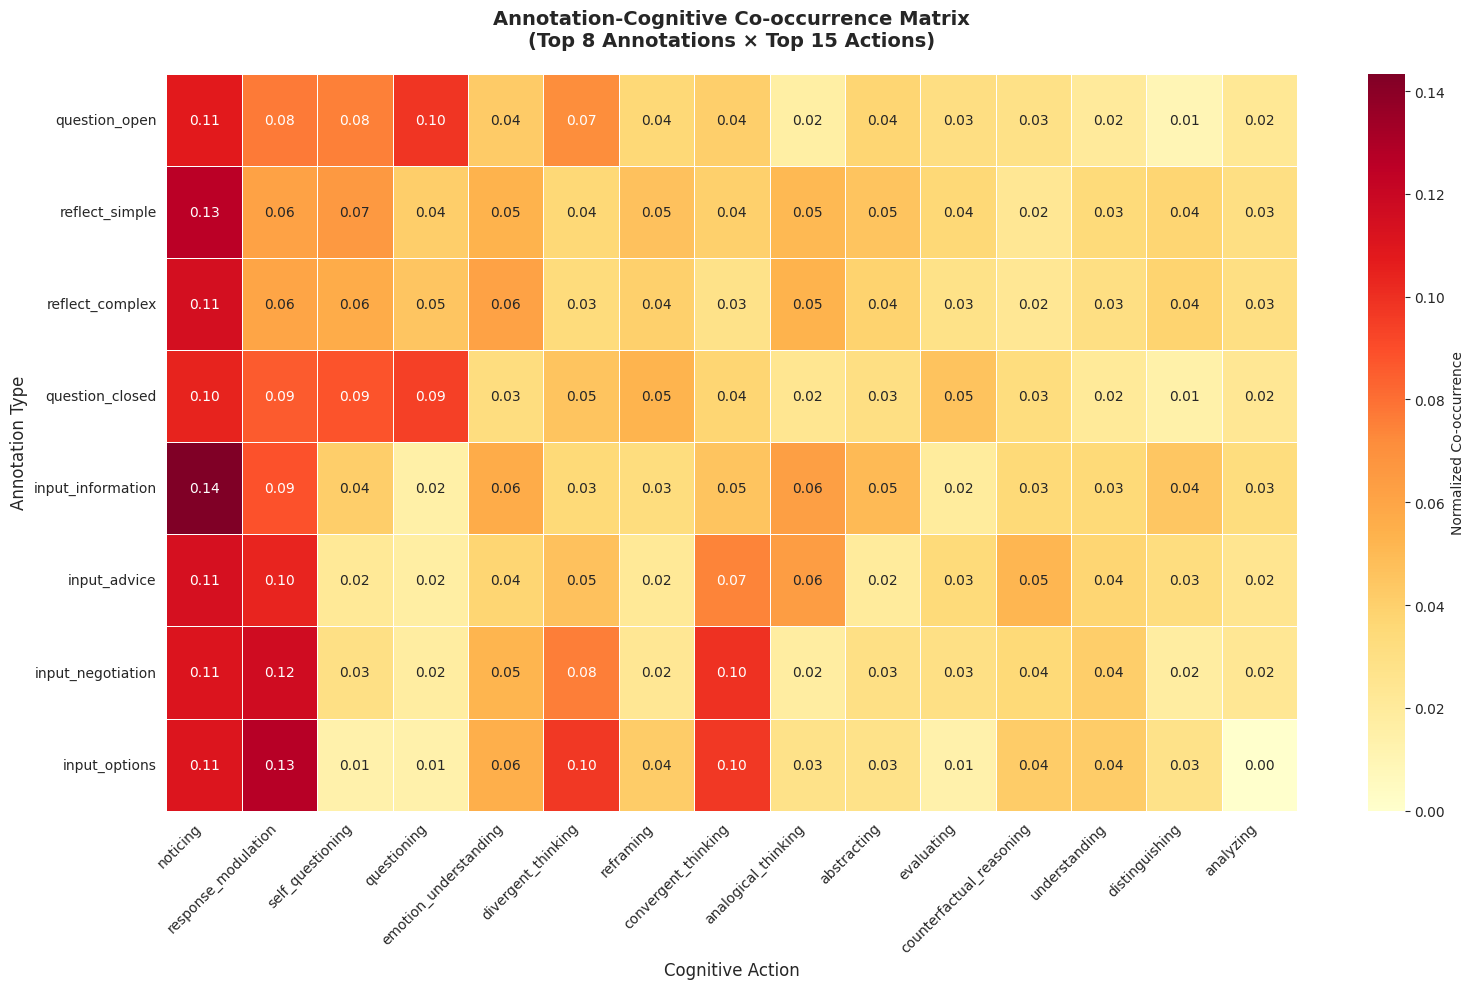

✅ Visualization saved: output/analysis_AnnoMI/synergy_2_cooccurrence_heatmap.png


In [7]:
# Visualize co-occurrence heatmap (top annotations and actions)
top_annotations = cooccur_pivot.sum(axis=1).nlargest(8).index
top_actions = cooccur_pivot.sum(axis=0).nlargest(15).index

cooccur_subset = cooccur_normalized.loc[top_annotations, top_actions]

fig, ax = plt.subplots(figsize=(16, 10))
sns.heatmap(cooccur_subset, cmap='YlOrRd', annot=True, fmt='.2f', 
            cbar_kws={'label': 'Normalized Co-occurrence'},
            ax=ax, linewidths=0.5)
ax.set_title('Annotation-Cognitive Co-occurrence Matrix\n(Top 8 Annotations × Top 15 Actions)',
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Cognitive Action', fontsize=12)
ax.set_ylabel('Annotation Type', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/synergy_2_cooccurrence_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/synergy_2_cooccurrence_heatmap.png")

## 5️⃣ Experiment 3: Predictive Modeling - MI Quality from Combined Features

**Question:** Can we predict MI quality better using both cognitive and annotation features?

In [8]:
print("="*80)
print("PREDICTIVE MODELING: MI QUALITY FROM COMBINED FEATURES")
print("="*80)

# Create features for each transcript
transcript_features = []

for transcript_id in df['transcript_id'].unique():
    t_df = df[df['transcript_id'] == transcript_id]
    t_therapist = t_df[t_df['interlocutor'] == 'therapist']
    
    if len(t_therapist) < 5:
        continue
    
    # Annotation features
    reflection_rate = (t_therapist['reflection_exists'] == True).sum() / len(t_therapist)
    question_rate = (t_therapist['question_exists'] == True).sum() / len(t_therapist)
    input_rate = (t_therapist['therapist_input_exists'] == True).sum() / len(t_therapist)
    
    simple_ref_rate = (t_therapist['reflection_subtype'] == 'simple').sum() / len(t_therapist)
    complex_ref_rate = (t_therapist['reflection_subtype'] == 'complex').sum() / len(t_therapist)
    open_q_rate = (t_therapist['question_subtype'] == 'open').sum() / len(t_therapist)
    closed_q_rate = (t_therapist['question_subtype'] == 'closed').sum() / len(t_therapist)
    
    # Cognitive features (top 10 most common actions)
    action_counts = Counter()
    for actions in t_therapist['action_names']:
        for action in actions:
            action_counts[action] += 1
    
    top_10_actions = [a for a, _ in Counter(
        action for actions in df['action_names'] for action in actions
    ).most_common(10)]
    
    action_features = {f'action_{action}': action_counts.get(action, 0) / len(t_therapist)
                      for action in top_10_actions}
    
    # Combined features
    features = {
        'transcript_id': transcript_id,
        'mi_quality': t_df['mi_quality'].iloc[0],
        'reflection_rate': reflection_rate,
        'question_rate': question_rate,
        'input_rate': input_rate,
        'simple_ref_rate': simple_ref_rate,
        'complex_ref_rate': complex_ref_rate,
        'open_q_rate': open_q_rate,
        'closed_q_rate': closed_q_rate,
        **action_features
    }
    
    transcript_features.append(features)

features_df = pd.DataFrame(transcript_features)
print(f"\n✅ Created feature matrix: {len(features_df)} transcripts × {len(features_df.columns)-2} features")

# Prepare for modeling
X = features_df.drop(['transcript_id', 'mi_quality'], axis=1).values
y = (features_df['mi_quality'] == 'high').astype(int).values

# Train Random Forest classifier with cross-validation
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

print(f"\n📊 Random Forest Cross-Validation Results:")
print(f"   Mean Accuracy: {scores.mean():.3f} (±{scores.std():.3f})")
print(f"   Min: {scores.min():.3f}, Max: {scores.max():.3f}")

# Train on full data to get feature importances
rf.fit(X, y)
feature_names = features_df.drop(['transcript_id', 'mi_quality'], axis=1).columns
importances = pd.DataFrame({
    'feature': feature_names,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📈 Top 10 Most Important Features:")
for i, row in importances.head(10).iterrows():
    print(f"   {row['feature']:35s} {row['importance']:.4f}")

PREDICTIVE MODELING: MI QUALITY FROM COMBINED FEATURES

✅ Created feature matrix: 128 transcripts × 17 features

📊 Random Forest Cross-Validation Results:
   Mean Accuracy: 0.898 (±0.020)
   Min: 0.880, Max: 0.923

📈 Top 10 Most Important Features:
   input_rate                          0.2490
   reflection_rate                     0.1801
   complex_ref_rate                    0.0750
   action_self_questioning             0.0601
   question_rate                       0.0510
   simple_ref_rate                     0.0476
   action_questioning                  0.0465
   action_convergent_thinking          0.0464
   action_evaluating                   0.0352
   action_response_modulation          0.0316


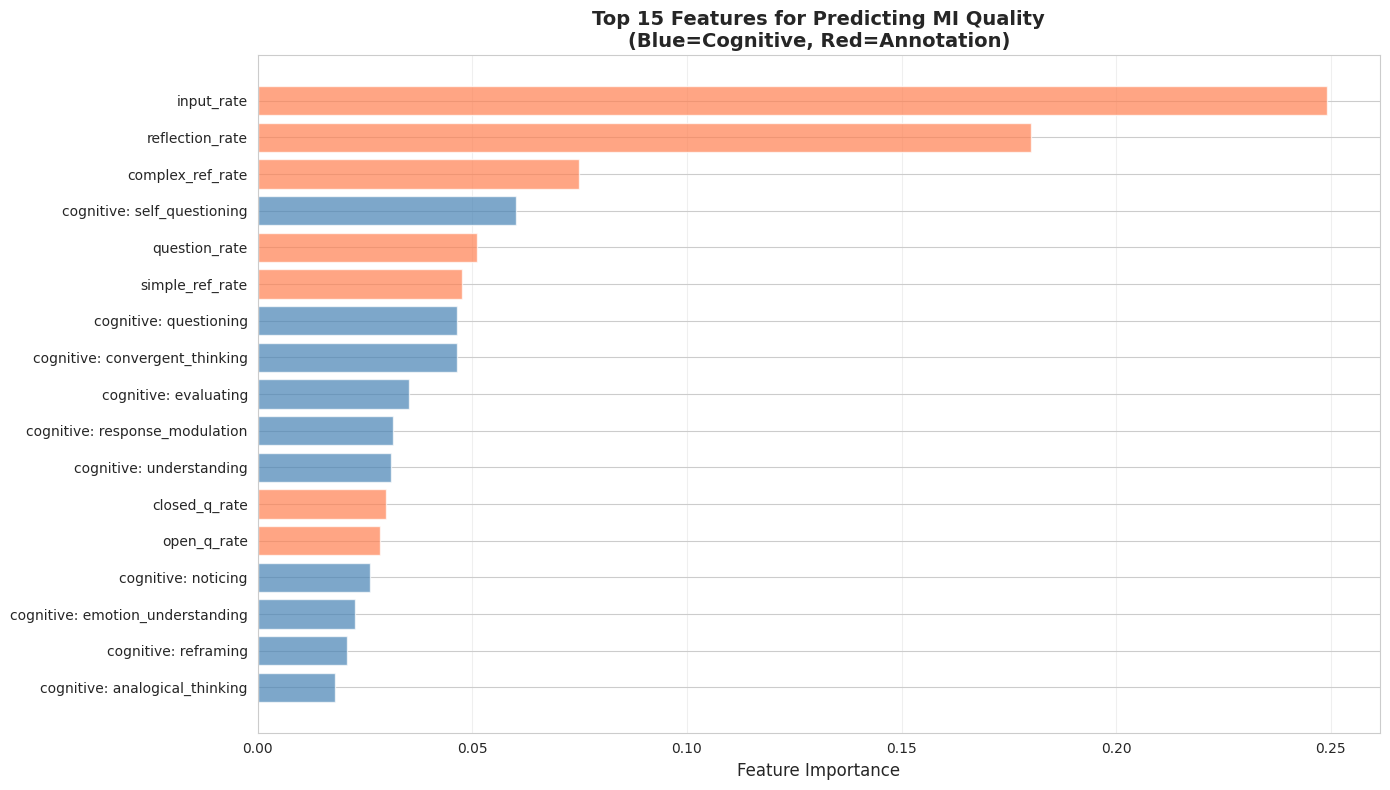

✅ Visualization saved: output/analysis_AnnoMI/synergy_3_feature_importance.png


In [ ]:
# Visualize feature importances
fig, ax = plt.subplots(figsize=(14, 8))

top_features = importances.head(15)
colors = ['steelblue' if 'action_' in f else 'coral' 
          for f in top_features['feature']]

ax.barh(range(len(top_features)), top_features['importance'], color=colors, alpha=0.7)
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['feature'].str.replace('action_', 'cognitive: '), fontsize=10)
ax.set_xlabel('Feature Importance', fontsize=12)
ax.set_title('Top 15 Features for Predicting MI Quality\n(Blue=Cognitive, Red=Annotation)',
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
ax.invert_yaxis()

plt.tight_layout()
plt.savefig('output/analysis_AnnoMI/synergy_3_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: output/analysis_AnnoMI/synergy_3_feature_importance.png")

## 6️⃣ Experiment 4: Client Response to Therapist Techniques

**Question:** What cognitive patterns appear in client responses after specific therapist techniques?

In [14]:
print("="*80)
print("CLIENT COGNITIVE RESPONSES TO THERAPIST TECHNIQUES")
print("="*80)

# Analyze therapist technique → client cognitive response patterns
response_patterns = defaultdict(list)

for transcript_id in df['transcript_id'].unique():
    t_df = df[df['transcript_id'] == transcript_id].sort_values('utterance_id')
    
    for i in range(len(t_df) - 1):
        current = t_df.iloc[i]
        next_utt = t_df.iloc[i+1]
        
        # If current is therapist and next is client
        if current['interlocutor'] == 'therapist' and next_utt['interlocutor'] == 'client':
            # Get therapist technique
            technique = None
            if current['reflection_exists'] == True:
                technique = f"reflect_{current['reflection_subtype']}"
            elif current['question_exists'] == True:
                technique = f"question_{current['question_subtype']}"
            elif current['therapist_input_exists'] == True:
                technique = "input"
            
            if technique and pd.notna(technique):
                # Get client cognitive response
                client_actions = next_utt['action_names']
                for action in client_actions:
                    response_patterns[technique].append(action)

# Analyze response patterns
technique_responses = {}
for technique, actions in response_patterns.items():
    action_counts = Counter(actions)
    technique_responses[technique] = action_counts.most_common(10)

print("\nClient cognitive responses following each technique:\n")
for technique, top_actions in technique_responses.items():
    print(f"{'='*80}")
    print(f"{technique.upper().replace('_', ' ')} → CLIENT RESPONSE")
    print(f"{'='*80}")
    for action, count in top_actions:
        pct = count / len(response_patterns[technique]) * 100
        print(f"   {action:35s} {count:4d} ({pct:5.1f}%)")
    print()

CLIENT COGNITIVE RESPONSES TO THERAPIST TECHNIQUES

Client cognitive responses following each technique:

INPUT → CLIENT RESPONSE
   self_questioning                     142 ( 11.7%)
   noticing                             132 ( 10.9%)
   reframing                            120 (  9.9%)
   response_modulation                   89 (  7.3%)
   evaluating                            75 (  6.2%)
   questioning                           59 (  4.9%)
   analogical_thinking                   56 (  4.6%)
   convergent_thinking                   44 (  3.6%)
   distinguishing                        39 (  3.2%)
   hypothesis_generation                 38 (  3.1%)

QUESTION OPEN → CLIENT RESPONSE
   noticing                             329 ( 11.2%)
   self_questioning                     233 (  7.9%)
   response_modulation                  219 (  7.5%)
   reframing                            217 (  7.4%)
   hypothesis_generation                174 (  5.9%)
   evaluating                           16

## 7️⃣ Experiment 5: Change Talk with Dual-Lens View

**Question:** What combination of therapist techniques and cognitive patterns precede client change talk?

In [15]:
print("="*80)
print("DUAL-LENS CHANGE TALK ANALYSIS")
print("="*80)


# Find patterns: therapist technique + cognitive → client change/sustain talk
change_precursors = []
sustain_precursors = []

for transcript_id in df['transcript_id'].unique():
    t_df = df[df['transcript_id'] == transcript_id].sort_values('utterance_id')
    
    for i in range(len(t_df) - 1):
        current = t_df.iloc[i]
        next_utt = t_df.iloc[i+1]
        
        if (current['interlocutor'] == 'therapist' and 
            next_utt['interlocutor'] == 'client' and
            pd.notna(next_utt['client_talk_type'])):
            
            # Get therapist technique
            technique = 'other'
            if current['reflection_exists'] == True:
                technique = f"reflect_{current['reflection_subtype']}"
            elif current['question_exists'] == True:
                technique = f"question_{current['question_subtype']}"
            elif current['therapist_input_exists'] == True:
                technique = "input"
            
            # Get therapist cognitive actions (top 3)
            therapist_actions = current['action_names'][:3] if len(current['action_names']) > 0 else []
            
            pattern = {
                'technique': technique,
                'therapist_actions': therapist_actions,
                'client_talk_type': next_utt['client_talk_type']
            }
            
            if next_utt['client_talk_type'] == 'change':
                change_precursors.append(pattern)
            elif next_utt['client_talk_type'] == 'sustain':
                sustain_precursors.append(pattern)

print(f"\n📊 Collected patterns:")
print(f"   Patterns preceding CHANGE talk: {len(change_precursors)}")
print(f"   Patterns preceding SUSTAIN talk: {len(sustain_precursors)}")

# Analyze most common technique-cognitive combinations for change talk
change_technique_counts = Counter(p['technique'] for p in change_precursors)
sustain_technique_counts = Counter(p['technique'] for p in sustain_precursors)

print("\n" + "="*80)
print("TECHNIQUES PRECEDING CHANGE TALK")
print("="*80)
for technique, count in change_technique_counts.most_common(10):
    pct = count / len(change_precursors) * 100
    print(f"   {technique:30s} {count:4d} ({pct:5.1f}%)")

print("\n" + "="*80)
print("THERAPIST COGNITIVE ACTIONS PRECEDING CHANGE TALK")
print("="*80)
change_actions = Counter()
for pattern in change_precursors:
    for action in pattern['therapist_actions']:
        change_actions[action] += 1

for action, count in change_actions.most_common(15):
    print(f"   {action:35s} {count:4d}")

DUAL-LENS CHANGE TALK ANALYSIS

📊 Collected patterns:
   Patterns preceding CHANGE talk: 784
   Patterns preceding SUSTAIN talk: 373

TECHNIQUES PRECEDING CHANGE TALK
   question_open                   273 ( 34.8%)
   reflect_simple                  151 ( 19.3%)
   reflect_complex                 133 ( 17.0%)
   question_closed                  95 ( 12.1%)
   other                            79 ( 10.1%)
   input                            53 (  6.8%)

THERAPIST COGNITIVE ACTIONS PRECEDING CHANGE TALK
   noticing                             234
   questioning                          176
   response_modulation                  149
   self_questioning                     147
   divergent_thinking                   142
   evaluating                           108
   abstracting                          102
   convergent_thinking                   99
   reframing                             92
   counterfactual_reasoning              68
   emotion_understanding                 63
   analogi

## 8️⃣ Summary and Export

In [12]:
print("="*80)
print("SYNERGISTIC ANALYSIS SUMMARY")
print("="*80)

summary = {
    'dataset': {
        'total_utterances': len(df),
        'transcripts': int(df['transcript_id'].nunique()),
        'with_annotations_and_cognitive': len(df[df['num_active_actions'] > 0]),
    },
    'technique_signatures': {
        tech: {'count': data['count'], 
               'top_5_actions': [a for a, _ in data['top_actions'][:5]]}
        for tech, data in technique_signatures.items()
    },
    'predictive_modeling': {
        'cross_val_accuracy_mean': float(scores.mean()),
        'cross_val_accuracy_std': float(scores.std()),
        'top_10_features': importances.head(10)['feature'].tolist(),
    },
    'change_talk_precursors': {
        'total_patterns': len(change_precursors),
        'top_techniques': dict(change_technique_counts.most_common(5)),
        'top_cognitive_actions': dict(change_actions.most_common(10)),
    },
}

# Save summary
with open('output/analysis_AnnoMI/synergistic_analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("\n✅ Summary saved: output/analysis_AnnoMI/synergistic_analysis_summary.json")
print("\n" + "="*80)
print("SYNERGISTIC ANALYSIS COMPLETE!")
print("="*80)
print("\nGenerated outputs:")
print("   1. synergy_1_technique_signatures.png")
print("   2. synergy_2_cooccurrence_heatmap.png")
print("   3. synergy_3_feature_importance.png")
print("   4. synergistic_analysis_summary.json")
print("\nKey Findings:")
print(f"   - Analyzed {len(technique_signatures)} MI technique signatures")
print(f"   - ML model accuracy: {scores.mean():.1%}")
print(f"   - {len(change_precursors)} patterns identified preceding change talk")

SYNERGISTIC ANALYSIS SUMMARY

✅ Summary saved: output/analysis_AnnoMI/synergistic_analysis_summary.json

SYNERGISTIC ANALYSIS COMPLETE!

Generated outputs:
   1. synergy_1_technique_signatures.png
   2. synergy_2_cooccurrence_heatmap.png
   3. synergy_3_feature_importance.png
   4. synergistic_analysis_summary.json

Key Findings:
   - Analyzed 4 MI technique signatures
   - ML model accuracy: 89.8%
   - 784 patterns identified preceding change talk
